# CAPSTONE PROJECT: BATTLE OF THE NEIGHBORHOODS (PART 2)


### Applied Data science Capstone by Vishaal Rao

## Introduction: Business Problem <a name="introduction"></a>

Let us consider a business owner planning to open a fast food resturant in Mumbai. She has approached us to recommend an ideal location to open this resturant.In this use case, an ideal location would be one that can maximise footfall in the resturant in order to maximize her profits.

Additionally, once provided an ideal location, she would also like to acquire:
  
  1. Average price range of the resturants nearby: This will allow her to design her price her offerings competitively.
  
  2. Average rating of the restaurants nearby: This will allow her to gauge her competition. For e.g. Highly rated resturants means going up against well established players.
  
  3. Combined total number of ratings of resturants nearby: This will not give the exact footfall but could be used to compare 2 locations. Location with greater number of ratings in most cases implies greater footfall.


## Our Approach:
Before we get started, I would like to incorporate a few of my experiences/ideas to optimise our approach to finding an ideal location:

  1. Mumbai has one of busiest commuter rail systems with over 7.5 million commuters daily. Locating a resturant near a rail station can result in a high footfall. I personally have visited some of the popular resturants near rail stations and have always found them jam packed!

  2. We should also optimise for locations with high densities of fast food resturants. This idea is based on the concept of game theory and Nesh equilibrium theorem, which imply that when shops of the same kind open close to one another, these shops tend to enjoy better profits.



## Methodology

Incorporating the aforementioned ideas, our solution will consist of the following steps:

1. Acquire the locations of fast food resturants in mumbai, along with their price-range, ratings. We shall utilise Foursqaure API for this.

2. Acquire the locations of rail stations in mumbai using the foursquare API.

3. Study the price-range, ratings and number of likes given to these eshtablishment in order to gt a better understanding of the competition

4. Clustering and understanding the locations with the high denstiy of fast food resturaunts using KMeans.

5. Removing all the outliers railway station which arent anywhere close to the clusters and marking the ones which are within 2 km of the cluster centres.

6. Since there is no dataset about the footfall in the stations we shall datascrape that information off a blog post and draw up a conclusion.



## Functions used in the following program

In [1]:
%matplotlib inline

import pandas as pd #For DataFrame Manipulation

import os #For accessing previously saved file

from geopy.geocoders import Nominatim #For accessing latitude and Longtitude

import folium #For Map Manipulation

import requests #For accessing url

import json #For json file manipulation

import numpy as np #Mathematical manipulation

from sklearn.cluster import KMeans #For clustering

import matplotlib.cm as cm #for plotting  on maps

import matplotlib.colors as colors #for color pallete

from math import radians, sin, cos, acos,isnan # To calculate the distance between 2 points based on Latitude and Longitude

from bs4 import BeautifulSoup # Data scraping

import requests # To get HTML file of web pages

import matplotlib.pyplot as plt

plt.style.use('ggplot')


### Foursquare API Details

In [2]:
CLIENT_ID = 'O4QXRWP31S2P4IFTE50GVWNNSH0MDF24YYFOIANX4RS55JGT' # your Foursquare ID
CLIENT_SECRET = '1Q31LNOALLLPX0TGLTDNOIBUQP0E3UJTRSSW5RVKPDSDWG4M' # your Foursquare Secret
VERSION = '20180323' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: O4QXRWP31S2P4IFTE50GVWNNSH0MDF24YYFOIANX4RS55JGT
CLIENT_SECRET:1Q31LNOALLLPX0TGLTDNOIBUQP0E3UJTRSSW5RVKPDSDWG4M


The few code blocks below help us getting details neccesary in our project.

The search command gives us the venue id of the venues based on the following inputs:

https://api.foursquare.com/v2/venues/search?

 - near        : It is the name of the area, district or city of interest. Here we chosen Mumbai
 
 - Category ID : The category ID is used to specify the type of venues we are looking for,"4bf58dd8d48988d16e941735" is the  category id for fast food resturaunts
 
 - Radius      : Radius in which the venue should be present, we have chosen most of mumbai main area
 
 - limit       : Number of venues(100) 

In [3]:
LIMIT = 100
radius =10000
url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&near=Mumbai&categoryId=4bf58dd8d48988d16e941735&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION,  
    radius, 
    LIMIT)

In [4]:
results = requests.get(url).json()
print("Venue IDs have been located")

Venue IDs have been located


In [5]:
Venue_ID=[]
for i in range(len(results['response']['venues'])):
    Venue_ID.append(results['response']['venues'][i]['id'])

Using the venue ID's collected in the previous api call, we will be getting the details of each venue using the venues call:
'https://api.foursquare.com/v2/venues/VENUE_ID'
<br> 


In [6]:
Details=[]

for i,v in enumerate(Venue_ID):
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
        v,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)
    
    Details.append(requests.get(url).json())
    
print("The details have been recieved")

The details have been recieved


From the above api call,the details of 'Name', 'Rating', 'Price', 'Latitude', 'Longitude' is taken and made into a dataframe
**DetailsPD**

In [7]:
Names=[]
Rating=[]
price=[]
Latitude=[]
Longitude=[]
likes=[]

for i in range(len(Details)):   
    Names.append(Details[i]['response']['venue']['name'])
    try:
        Rating.append(Details[i]['response']['venue']['rating'])
    except:
        Rating.append(np.nan)
    price.append(Details[i]['response']['venue']['price']['tier'])  
    Latitude.append(Details[i]['response']['venue']['location']['lat'])
    Longitude.append(Details[i]['response']['venue']['location']['lng'])
    likes.append(Details[i]['response']['venue']['likes']['count'])

In [8]:
DetailsPD = pd.DataFrame(
    {'Names': Names,
     'Rating': Rating,
     'Price': price,
     'Latitude': Latitude,
     'Longitude': Longitude,
     'Number of likes':likes
    })

In [9]:
DetailsPD.head()

,Names,Rating,Price,Latitude,Longitude,Number of likes
0,McDonald's,6.6,1,19.072822,72.866768,3
1,Shiv Sagar,7.0,2,19.098715,72.827614,45
2,McDonald's,7.5,1,19.141247,72.825579,37
3,McDonald's,6.6,1,19.065785,72.834304,66
4,McDonald's,6.8,1,19.165871,72.937905,45


In [10]:
DetailsPD['Rating'].fillna(round((DetailsPD['Rating'].mean())), inplace=True) #NA is converted to mean in 'Rating'

In [11]:
latitude=19.0760
longitude=72.8777  #Mumbai lat long

In [12]:
mumbai_map = folium.Map(location = [latitude, longitude], zoom_start = 12) #Declaring the map

In [13]:
#Map for marking all the fast food joints collected

mark = folium.map.FeatureGroup()

for lat, lng, in zip(DetailsPD.Latitude, DetailsPD.Longitude):
    mark.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, 
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
mumbai_map.add_child(mark)

In [14]:
X=DetailsPD.loc[:,['Latitude','Longitude']] #Getting Lat Long

### Getting Location details for railway stations

Same as above, here we are using the search function with similar inputs, with only difference being the category ID which is
'4bf58dd8d48988d129951735' which represents the train stations.

In [15]:
Rails=[]
VERSION='20180323'
for i,v in enumerate(Venue_ID):
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&categoryId=4bf58dd8d48988d129951735&near=Mumbai&radius=25000'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)
    
    Rails.append(requests.get(url).json())

Creating a dataframe RailsPD with columns 'RNames','Rlatitude', 'Rlongitude'.

In [16]:
RNames=[]
RLatitude=[]
RLongitude=[]



for j in range(len(Rails[0]['response']['venues'])):
    RNames.append(Rails[0]['response']['venues'][j]['name']) 
    RLatitude.append(Rails[0]['response']['venues'][j]['location']['lat'])
    RLongitude.append(Rails[0]['response']['venues'][j]['location']['lng'])

In [17]:
RailsPD = pd.DataFrame(
    {'Names': RNames,
     'Latitude': RLatitude,
     'Longitude': RLongitude
    })

Since one of the clusters was heavily focused around a station which was not present in the foursquare venues we will be adding it manually

In [18]:
RailsPD.loc[30] = ['Goregaon railway station',19.1646,72.8493]

In [19]:
RailsPD.head()

,Names,Latitude,Longitude
0,Kurla Railway Station,19.065333,72.879335
1,Chhatrapati Shivaji Maharaj Terminus,18.940297,72.835384
2,Churchgate Railway Station,18.934706,72.827329
3,Thane Railway Station,19.186344,72.976082
4,Marol Naka Metro Station,19.108143,72.879373


## Getting the top 10 most liked fast food restauraunts around mumbai

In [20]:
DetailsPD.sort_values(by=['Number of likes'],ascending=False).head() #Top 10 

,Names,Rating,Price,Latitude,Longitude,Number of likes
27,Candies,8.6,2,19.049709,72.829785,179
25,Carter's Blue,8.7,1,19.070783,72.823045,127
16,McDonald's,7.4,1,19.119691,72.846102,110
30,The Daily,7.6,1,19.060917,72.837070,103
3,McDonald's,6.6,1,19.065785,72.834304,66


In [21]:
Bar=DetailsPD.sort_values(by=['Number of likes'],ascending=False).head(10).loc[:,['Names','Number of likes']]
Bar.set_index('Names')

,Number of likes
Names,
Candies,179
Carter's Blue,127
McDonald's,110
The Daily,103
McDonald's,66
McDonald's,54
D.P's Fast Food Centre,52
McDonald's,49
McDonald's,49


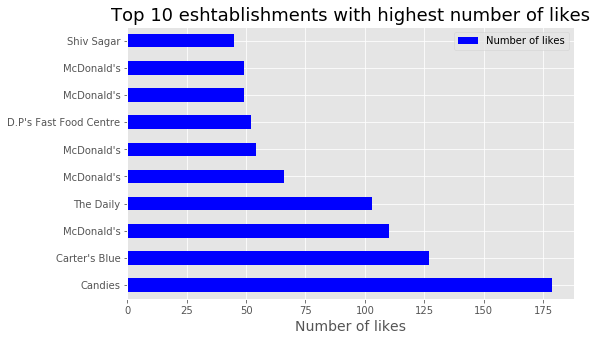

In [22]:
Bar.plot(x='Names',kind='barh', figsize=(8, 5),color='Blue')

plt.title('Top 10 eshtablishments with highest number of likes',fontsize=18)
plt.ylabel('',fontsize=14) # add y-label
plt.xlabel('Number of likes',fontsize=14) # add x-label

plt.show()

In [23]:
Boxplot=DetailsPD.loc[:,['Names','Rating']]

In [51]:
RatingMean=Boxplot.groupby('Names').mean()

In [68]:
RatingMean.sort_values(by=['Rating'],ascending=False).head(5)

,Rating
Names,
Carter's Blue,8.7
Candies,8.6
Gulati Sweets and Snacks,8.2
Tibbs,7.9
Trupti,7.8


In [64]:
color = dict(boxes='Blue', whiskers='Blue',medians='Black', caps='Gray')

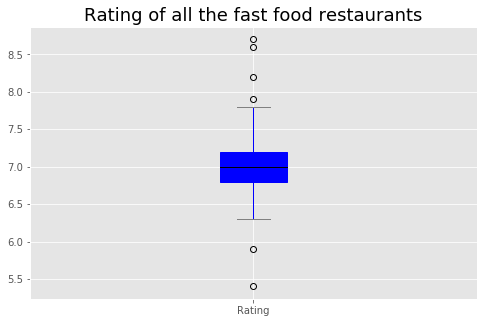

In [67]:
RatingMean.plot(kind='box', figsize=(8, 5),color=color,patch_artist=True)

plt.title('Rating of all the fast food restaurants',fontsize=18) 
#plt.ylabel('Rating',fontsize=14) # add y-label
plt.xlabel('',fontsize=14) # add x-label

plt.show()

## The average rating and price of the resturaunts in the area

In [24]:
print("the average rating of the resturaunts is",round(DetailsPD.Rating.mean(),2))
print("The average price range of resturaunts is",round(DetailsPD.Price.mean(),2),"(1 being cheap and 4 being expensive)")

the average rating of the resturaunts is 6.99
The average price range of resturaunts is 1.14 (1 being cheap and 4 being expensive)


## Clustering

In [25]:
#Clustering

# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 0, 2, 0, 1, 0, 4, 3, 1, 2])

In [26]:
# add clustering labels
X.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
DetailsPD_merged = X.merge(DetailsPD, on=['Latitude','Longitude'])



In [27]:
DetailsPD_merged.head(10)

,Cluster Labels,Latitude,Longitude,Names,Rating,Price,Number of likes
0,4,19.072822,72.866768,McDonald's,6.6,1,3
1,0,19.098715,72.827614,Shiv Sagar,7.0,2,45
2,2,19.141247,72.825579,McDonald's,7.5,1,37
3,0,19.065785,72.834304,McDonald's,6.6,1,66
4,1,19.165871,72.937905,McDonald's,6.8,1,45
5,0,19.100573,72.840708,McDonald's,6.2,1,36
6,4,19.106139,72.884878,McDonald's,6.5,1,34
7,3,19.023367,72.849494,D.P's Fast Food Centre,7.5,1,52
8,1,19.141418,72.932039,McDonald's,5.5,1,15
9,2,19.132426,72.812571,Subway,6.3,1,11


In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(DetailsPD_merged['Latitude'], DetailsPD_merged['Longitude'], DetailsPD_merged['Names'], DetailsPD_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

dropping the stations which are **nowhere close to** any of the fast food venues

In [29]:
RailsPD = RailsPD.drop(RailsPD[(RailsPD.Latitude < 19.007698) | (RailsPD.Latitude > 19.164600) | (RailsPD.Longitude > 72.927984)].index)

In [30]:
RailsPD.reset_index(inplace=True,drop=True)
RailsPD.head()

,Names,Latitude,Longitude
0,Kurla Railway Station,19.065333,72.879335
1,Marol Naka Metro Station,19.108143,72.879373
2,Wadala Railway Station,19.016792,72.858589
3,Dadar Railway Station,19.018678,72.843214
4,Bandra Terminus,19.063308,72.841217


In [31]:
Rmap = folium.Map(location=[latitude, longitude], zoom_start=11)
Z = folium.map.FeatureGroup()
# loop through the stations names
for lat, lng, in zip(RailsPD.Latitude, RailsPD.Longitude):
    Z.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='black',
            fill_opacity=0.6
        )
    )

# add incidents to map
Rmap.add_child(Z)

The below code calculates the distance between 2 points using their Latitude and Longitude

In [32]:
def dist(Rlat,Rlon,Clat,Clon):
    
    Rlat = radians(Rlat)
    Rlon = radians(Rlon)
    Clat = radians(Clat)
    Clon = radians(Clon)
    
    dist = 6371.01 * acos(sin(Rlat)*sin(Clat) + cos(Rlat)*cos(Clat)*cos(Rlon - Clon))
    return dist

In [33]:
KClusterCent=pd.DataFrame(list(kmeans.cluster_centers_))

The following code gives all the stations which are within **2km** radius of the cluster centre 

In [34]:
C2C=[]
CNo=[]
for i in range(len(kmeans.cluster_centers_)):
    for j in range(len(RailsPD)):
        x=dist(RailsPD.iloc[j,1],RailsPD.iloc[j,2],KClusterCent.iloc[i,0],KClusterCent.iloc[i,1])
        
        if x<2:
            C2C.append(RailsPD.iloc[j,0])
            CNo.append(i)
            print("The station {} is close to cluster {} with a distance of {} km".format(RailsPD.iloc[j,0],i,round(x,3)))

The station Bandra Terminus is close to cluster 0 with a distance of 1.505 km
The station Santacruz Railway Station is close to cluster 0 with a distance of 0.794 km
The station Jogeshwari Railway Station is close to cluster 2 with a distance of 1.195 km
The station Dadar Railway Station is close to cluster 3 with a distance of 1.066 km
The station Elphinstone Road Railway Station is close to cluster 3 with a distance of 0.388 km
The station Vidyavihar Railway Station is close to cluster 4 with a distance of 1.684 km


## Data scraping the **top 10 busiest Railway stations in mumbai** with their Foot fall

In [35]:
website_url = requests.get("https://nearfox.com/mumbai/10-busiest-stations-in-mumbai/").text
busy=BeautifulSoup(website_url,'lxml')
busy10=busy.find('div',{'class':'entry-content'})

In [36]:
Heading=list(map(str,busy10.findAll('h2')))

In [37]:
for i in range(len(Heading)):
    Heading[i]=Heading[i][4:-5] #To remove <h2></h2>

In [38]:
Heading.remove("Kalyan Station") #Kalyan station didnt follow the pattern while we underwent data scraping and as it was no where within 2 km of fast food resturaunts we decided to drop it.

In [39]:
strB10=str(busy10)

In [40]:
No=[]
indexN=[]
n="lakh"
for i,_ in enumerate(strB10):
    if strB10[i:i+len(n)]=="lakh":
        indexN.append(i)
    
    
for i,j in enumerate(indexN):
    No.append(strB10[j-6:j])

## Top 10 station with highest footfall

In [41]:
footfall=pd.DataFrame({'Station':Heading,'Footfall in Lakhs':No})
footfall

,Station,Footfall in Lakhs
0,Thane Station,6.54
1,Chhatrapati Shivaji Terminus Station (CST),6.36
2,Andheri Station,6.04
3,Dadar Station,5.77
4,Churchgate Station,5.05
5,Bandra Station,4.91
6,Virar Station,3.95
7,Kurla Station,3.81
8,Nallasopara Station,3.25


In [42]:
C2C=pd.DataFrame({'Station':C2C,'Cluster No':CNo})
C2C

,Station,Cluster No
0,Bandra Terminus,0
1,Santacruz Railway Station,0
2,Jogeshwari Railway Station,2
3,Dadar Railway Station,3
4,Elphinstone Road Railway Station,3
5,Vidyavihar Railway Station,4


In [43]:
A=C2C.merge(RailsPD,how='inner',left_on='Station',right_on='Names')

In [44]:
A.drop('Station',axis=1,inplace= True)
A

,Cluster No,Names,Latitude,Longitude
0,0,Bandra Terminus,19.063308,72.841217
1,0,Santacruz Railway Station,19.081106,72.842123
2,2,Jogeshwari Railway Station,19.136533,72.848797
3,3,Dadar Railway Station,19.018678,72.843214
4,3,Elphinstone Road Railway Station,19.007698,72.835719
5,4,Vidyavihar Railway Station,19.079478,72.897409


In [45]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon in zip(KClusterCent[0], KClusterCent[1]):
    folium.Circle(
        [lat, lon],
        radius=2000,
        color=rainbow[0],
        fill=True,
        fill_color=rainbow[1],
        fill_opacity=0.2).add_to(map_clusters)

for lat, lon,lab in zip(A.Latitude, A.Longitude,A.Names):
    label = folium.Popup(str(lab), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        popup=label,
        radius=5,
        color='yellow',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

## Results and Discussion

In our analysis it is seen that most of the fast food resturaunts is around 5 different areas and out of these 5 areas 2 of the areas have 2 different stations in a 2 km radius from the cluster radius. the 4 stations are as follows:

 - Elphinstone Road Railway Station
 - Dadar Railway Station
 - Bandra Terminus
 - Santacruz Railway Station
 
 
 Out of the 4 stations **Dadar** and **Bandra** are considered in the top 10 footfall list with Dadar having a footfall of approx **5.71** lakhs per day and Bandra having **4.91** lakhs per day
 
The competeitors in this area have a relatively cheap options and a rating of around 7.

It is also noticed that individual privately owned resturaunts hold a **lot more popularity** than the massive chains such as Mcdonalds.

Our advice to the buisness owner would be to open either near **Bandra or Dadar**, having **cheap options** in order to get a decent rating. 


## Further Enhancements

this is methodology can be applied better using even more deciding factors such as tourist areas, schools, offices etc. and the a better idea of the competitors could be achieved if more information on footfall, services available etc could be obtained. This can be implemented for any type of eshtablishment as well.

A Linear regression could also have been done within the final 2 selected stations using rating as a dependent variable and distance from transports, tourist area, potential crowd in the area.

## Other problem statements we could tackle using adopted solution

The purpose of this project was to identify the area with the highest density of fast food resturaunts and to analyse the potential of high foot fall due to rail services.

This can be implemented for any type of eshtablishment as well. it can include any type of restaurant or shop which will be affected by the number of people passing by